In [38]:
library(tidyverse)
# Run this cell before continuing.
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)

library(datateachr)


In [39]:
# data <- read_csv("data/pppub22-concatenated.csv") 
    
# colnames(data) <- c("id", "age", "sex", "income") 

# data <- data |>
#     filter(income > 0,
#            age >= 18) |>
#     mutate(sex = as_factor(sex))

# data_sample <- data |>
#     rep_sample_n(size = 500)

In [40]:
# samp_dist <- data_sample |>
#   specify(formula = income ~ sex) %>% 
#   # hypothesize(null = "independence") %>% 
#   generate(size = 5000, reps = 1000, type = "bootstrap") %>% 
#   calculate(stat = "diff in means")

# obs_test_data <- mean(samp_dist$stat)

# samp_dist

# obs_test_data

In [41]:
# null_dist <- samp_dist |>
#   mutate(stat = stat + (0 - obs_test_data))

# visualize(null_dist) +
#     shade_p_value(obs_test_data, direction = 'right')

In [58]:
set.seed = 4850

# p_value <- null_dist |>
#     get_p_value(obs_stat = obs_test_data, direction = 'right')

In [51]:
# read data file

data <- read_csv("data//ds_salaries.csv")

# clean up columns 

data <- data |>
    mutate(id = ...1) |>
    select(-...1) |>
    filter(!is.na(salary_in_usd), job_title == "Data Analyst" | job_title == "Data Scientist")

# generate bootstrap samples and find difference in means

samp_dist <- data |>
  specify(formula = salary_in_usd ~ job_title) %>% 
  # hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "bootstrap") %>% 
  calculate(stat = "diff in means")

# the testing value

obs_test_data <- mean(samp_dist$stat)

obs_test_data

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "Data Analyst" - "Data Scientist", or divided in the order "Data Analyst" / "Data Scientist" for ratio-based statistics. To specify this order yourself, supply `order = c("Data Analyst", "Data Scientist")` to the calculate() function.”


[1] -15276.76

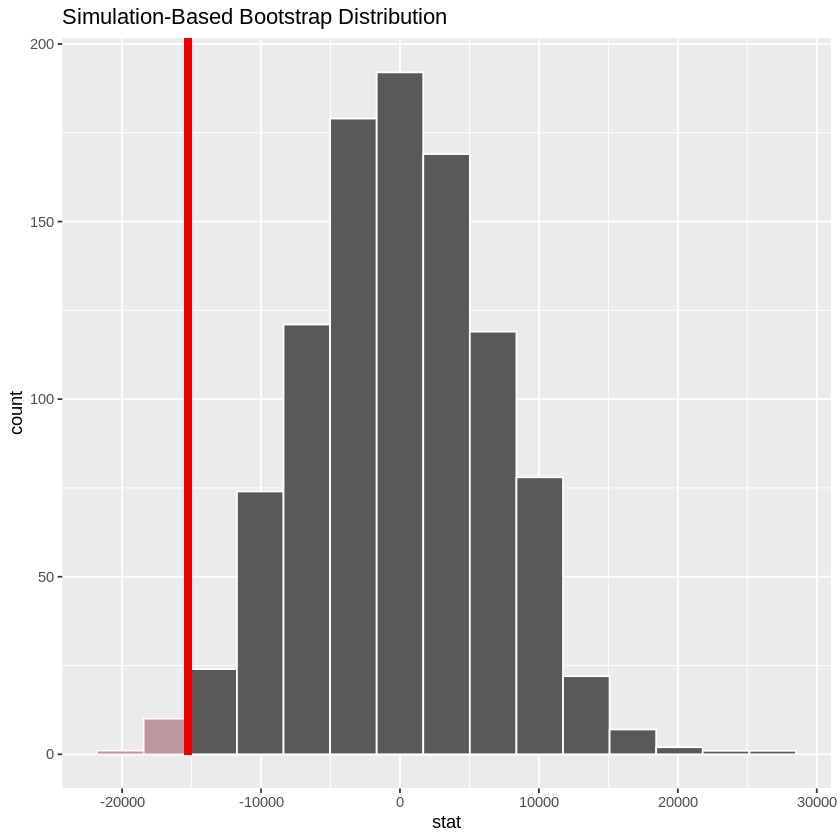

In [56]:
# shift sample distribution to make it a null distribution
null_dist <- samp_dist |>
  mutate(stat = stat + (0 - obs_test_data))

# graph distribution alongisde test value and shading

visualize(null_dist) +
    shade_p_value(obs_test_data, direction = 'left')

In [57]:
null_dist |> get_p_value(obs_test_data, direction = 'left')

p_value
<dbl>
0.011
